In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
from hmmlearn import hmm
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 30
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

In [3]:
def show_graph(data):
    plt.plot(data['DCOILWTICO'])
    plt.xlabel('Date')
    plt.ylabel('Oil Prices')
    plt.title('Trend of Crude Oil Prices')
    plt.show()
     
def get_trend(data):
    return [data[i - 1] < data[i] for i in range(1, len(data))]

def get_moving_averages(data, window_size):
    return [stats.mean(data[i: i + window_size]) for i in range(len(data) - window_size)]

def get_moving_window_dataframes(data, window_size):
    averages, trends = pd.DataFrame(), pd.DataFrame()
    averages['DCOILWTICO'] = get_moving_averages(data['DCOILWTICO'], window_size)
    trends['DCOILWTICO'] = get_trend(averages['DCOILWTICO'])
    return averages, trends

def split_to_prediction_windows(data, prediction_window):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], 1)
    return x, np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size)
    return x_train, y_train, x_test, y_test

def inverse_transform_single_column(scaler, y_values):
    return scaler.inverse_transform(np.array([[y, 0, 0, 0, 0, 0] for y in y_values]))[:, 0]

def train_model(x_train, y_train, units, dropout, num_lstm_layers, model_type):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'lstm' 
            else GRU(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'gru' 
            else SimpleRNN(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True) if model_type == 'lstm' else 
            GRU(units, return_sequences=True) if model_type == 'gru' else
            SimpleRNN(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units) if model_type == 'lstm' else 
            GRU(units) if model_type == 'gru' else
            SimpleRNN(units),
            Dropout(dropout),
            Dense(1)
        ])
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
    return model, history

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
def plot_prediction(scaler, x_test, y_test, model):
    y_predict = model.predict(x_test)
    plt.plot(inverse_transform_single_column(scaler, y_test), color='blue',label='Real Price')
    plt.plot(inverse_transform_single_column(scaler, y_predict), color='red',label='Predicted Price')
    plt.title('Crude Oil Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
def calculate_mse(x_test, y_test, model):
    y_predict = model.predict(x_test)
    mse = 0
    for i in range(len(y_predict)):
        mse += (y_predict[i] - y_test[i]) ** 2
    return mse

In [4]:
oil_prices = pd.read_csv('oil_prices.csv', index_col='DATE', parse_dates=['DATE'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
oil_prices = oil_prices[oil_prices['DCOILWTICO'] != '.']
oil_prices['DCOILWTICO'] = pd.to_numeric(oil_prices['DCOILWTICO'])
oil_prices.head()

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


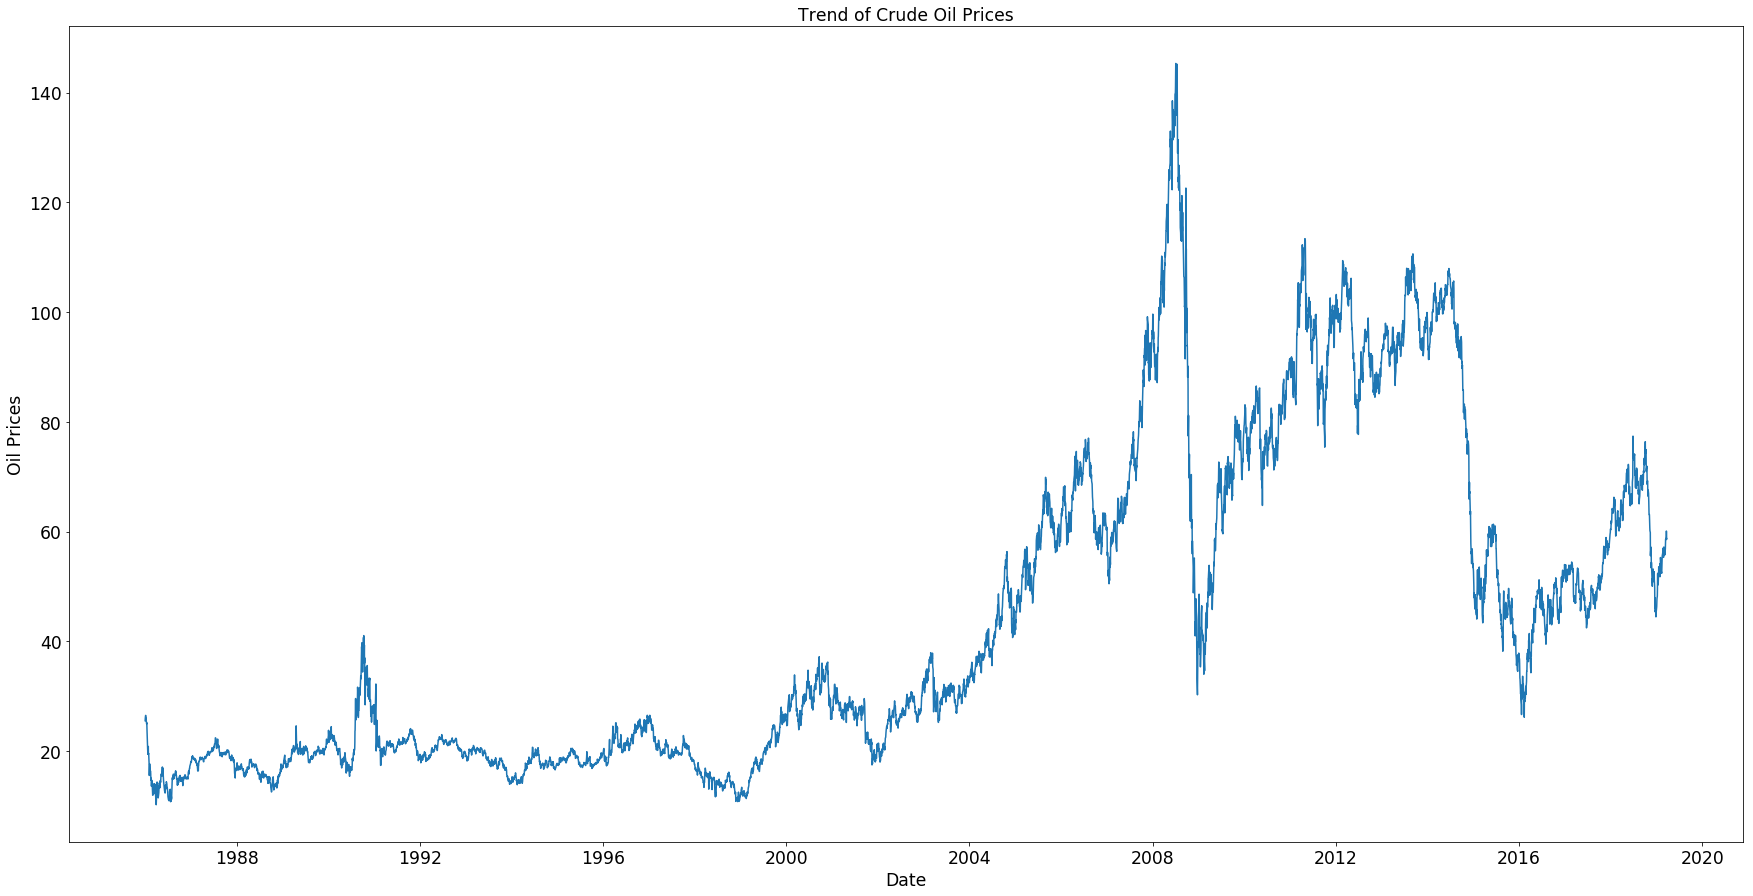

In [5]:
show_graph(oil_prices)

In [6]:
averages, trends = get_moving_window_dataframes(oil_prices, MOVING_AVERAGE_WINDOW_SIZE)

In [7]:
averages.head()

,DCOILWTICO
0,21.224667
1,20.920333
2,20.588000
3,20.193667
4,19.834667


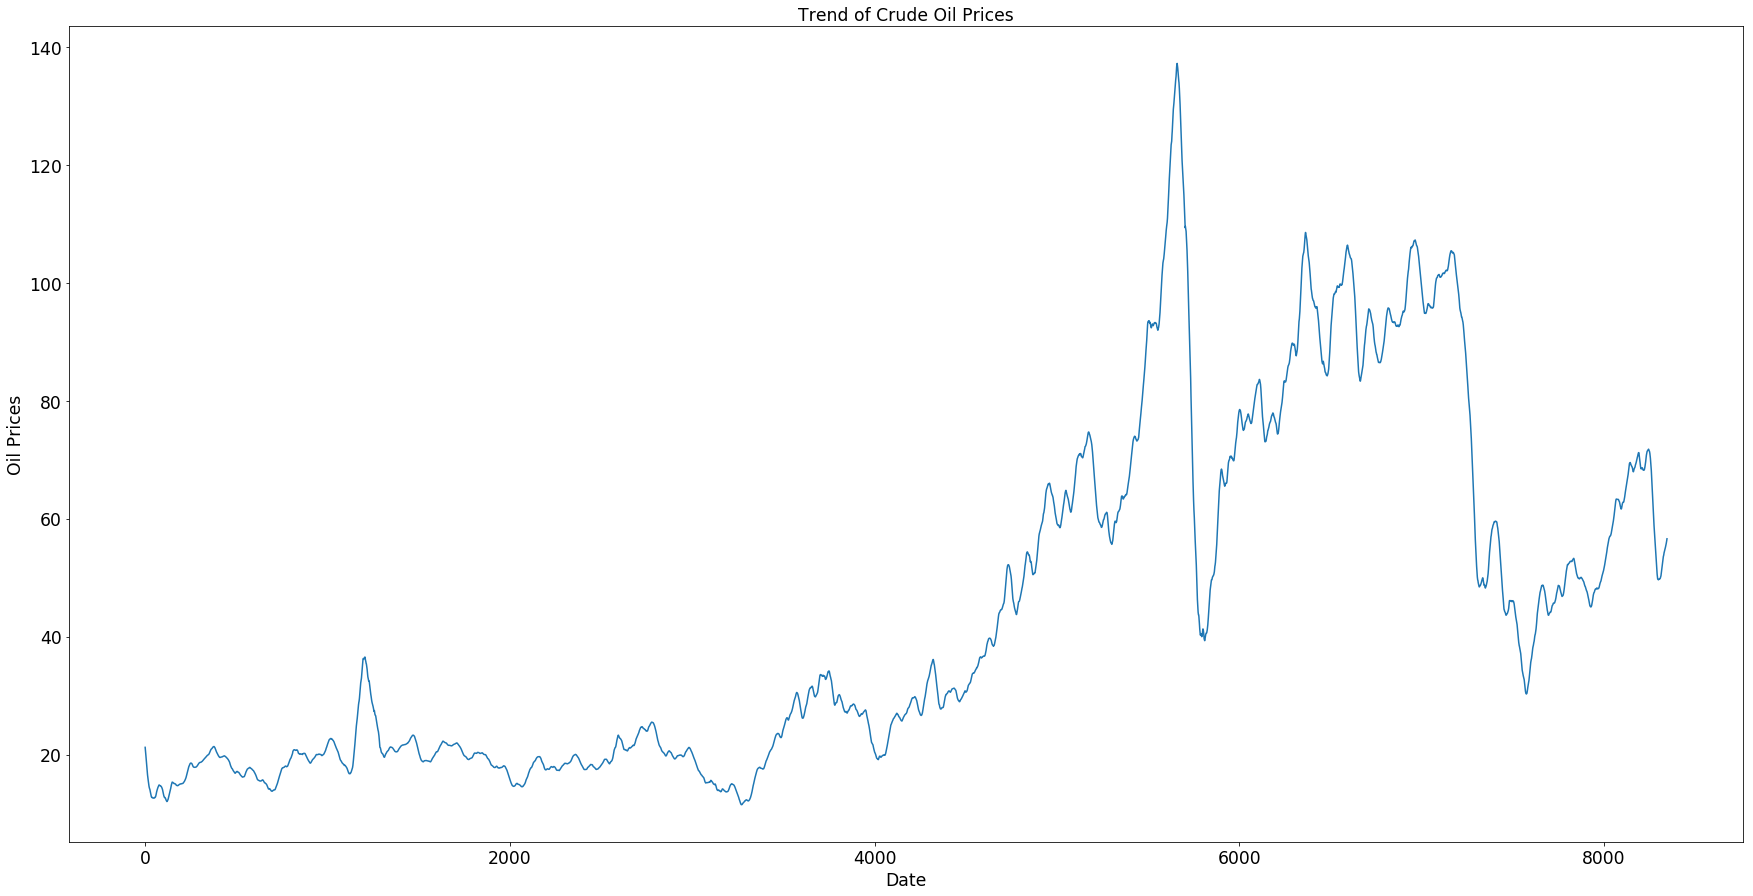

In [8]:
show_graph(averages)

# Hidden Markov Model

In [24]:
recent_trends = trends[-3000:].as_matrix().astype(int)
remodel = hmm.MultinomialHMM(n_components=5, n_iter=200)
remodel.fit(recent_trends[:2000])
test_set = recent_trends[2000:]
predictions = remodel.predict(test_set)
accuracy = (predictions == test_set.flatten()).sum() * 100 / len(predictions)
'Accuracy for Hidden Markov Model is {}%.'.format(accuracy)

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


'Accuracy for Hidden Markov Model is 38.8%.'

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
matrix = scaler.fit_transform(averages[-3000:])
matrix_train = matrix[:2000]
matrix_test = matrix[2000:]
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(matrix_train, matrix_test, PREDICTION_WINDOW_SIZE)

# RNN Model

In [11]:
rnn_model, rnn_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'rnn')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.4004
Epoch 2/100
1950/1950 [==============================] - 2s 920us/step - loss: 0.2266
Epoch 3/100
1950/1950 [==============================] - 2s 925us/step - loss: 0.1437
Epoch 4/100
1950/1950 [==============================] - 2s 923us/step - loss: 0.0873
Epoch 5/100
1950/1950 [==============================] - 2s 907us/step - loss: 0.0491
Epoch 6/100
1950/1950 [==============================] - 2s 906us/step - loss: 0.0293
Epoch 7/100
1950/1950 [==============================] - 2s 909us/step - loss: 0.0176
Epoch 8/100
1950/1950 [==============================] - 2s 901us/step - loss: 0.0103
Epoch 9/100
1950/1950 [==============================] - 2s 901us/step - loss: 

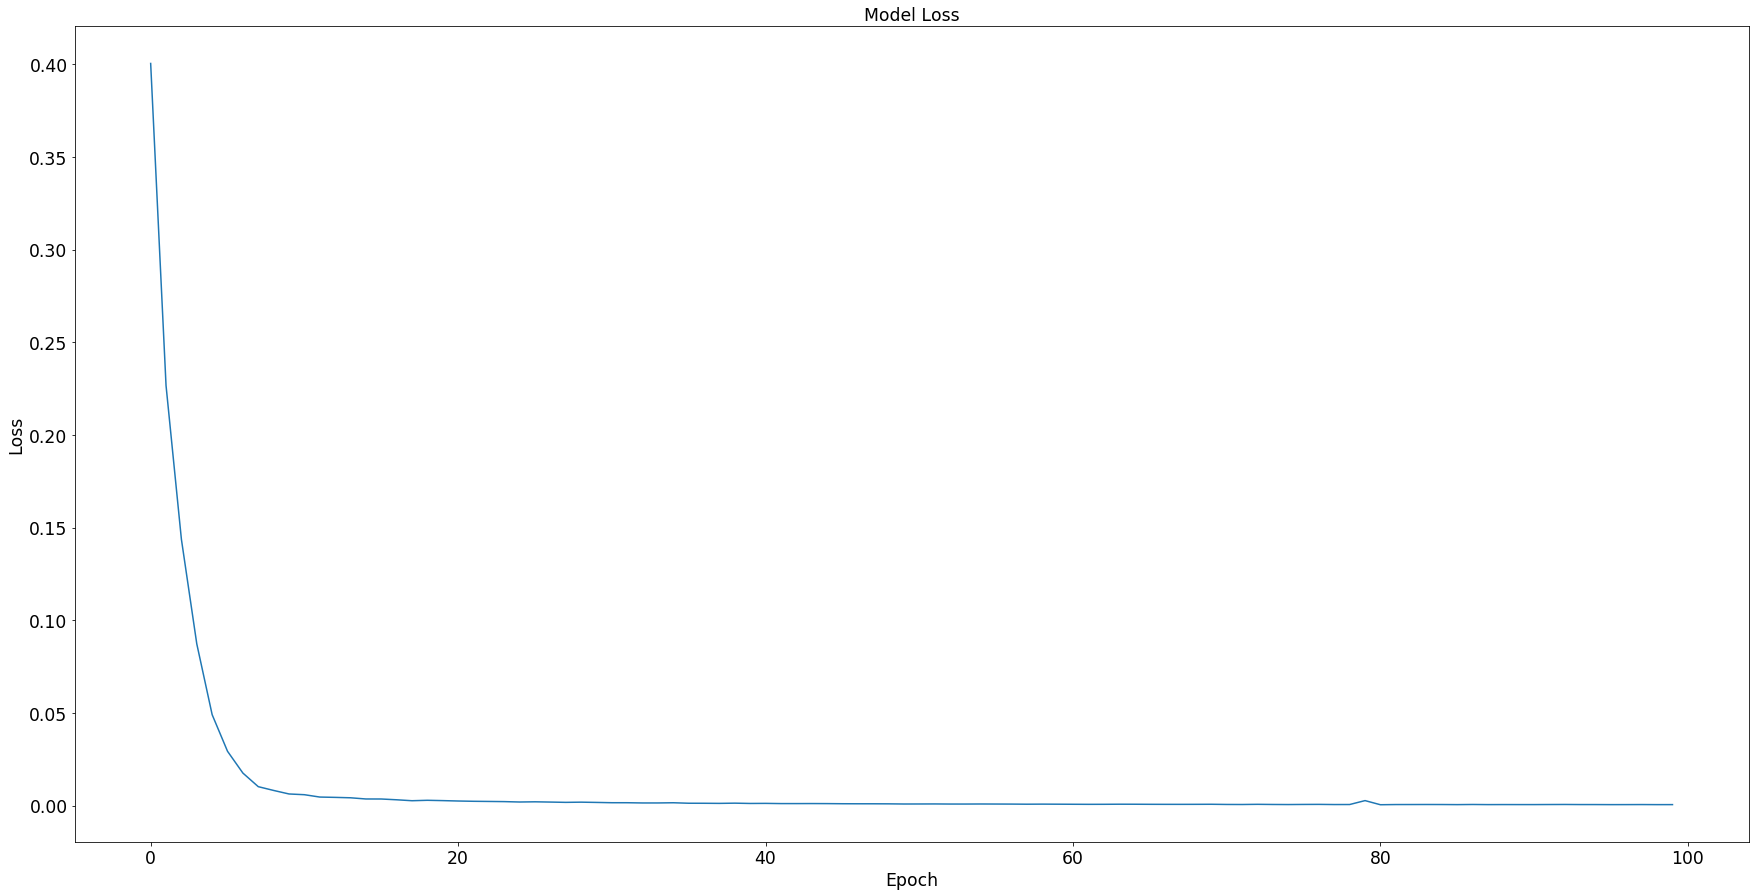

In [12]:
plot_loss(rnn_history)

In [23]:
rnn_mse = calculate_mse(x_test, y_test, rnn_model)
'Mean Square Error for RNN is {}.'.format(rnn_mse)

'Mean Square Error for RNN is [0.15069915].'

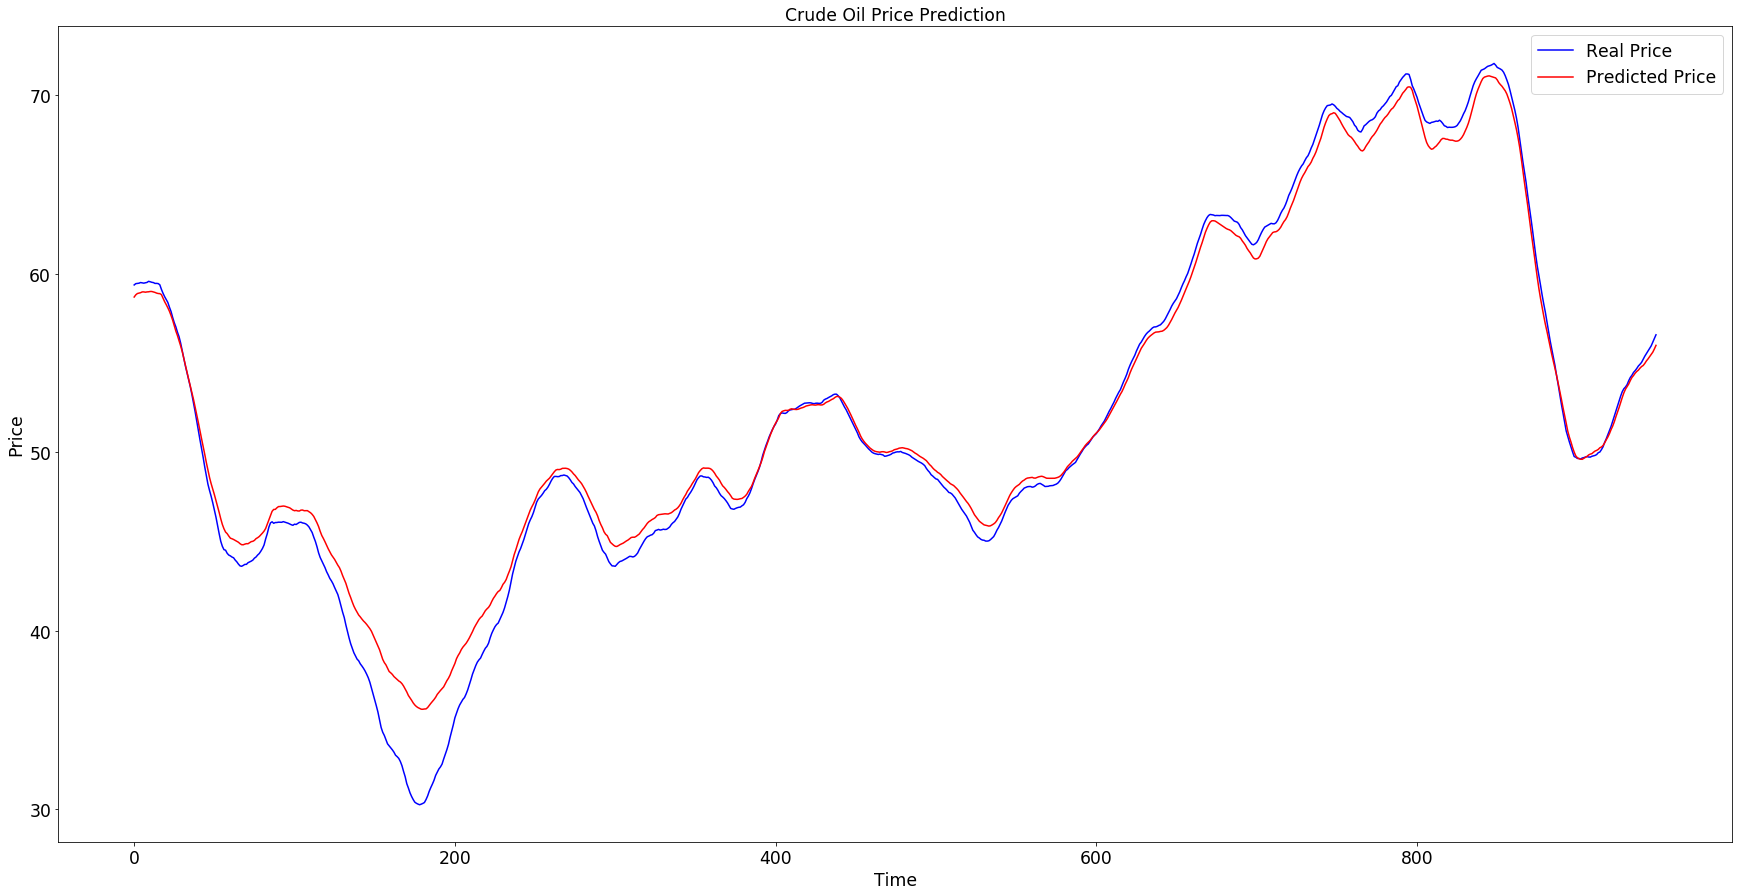

In [14]:
plot_prediction(scaler, x_test, y_test, rnn_model)

# LSTM Model

In [15]:
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm')

Epoch 1/100
1950/1950 [==============================] - 7s 4ms/step - loss: 0.0225
Epoch 2/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0098
Epoch 3/100
1950/1950 [==============================] - 6s 3ms/step - loss: 0.0078
Epoch 4/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0070
Epoch 5/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0061
Epoch 6/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0049
Epoch 7/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0044
Epoch 8/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0044
Epoch 9/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0035
Epoch 10/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0038
Epoch 11/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0033
Epoch 12/100
1950/1950 [==============================] - 5s 3ms/step - lo

1950/1950 [==============================] - 6s 3ms/step - loss: 4.9545e-04
Epoch 96/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.8728e-04
Epoch 97/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.5945e-04
Epoch 98/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.4977e-04
Epoch 99/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.7826e-04
Epoch 100/100
1950/1950 [==============================] - 6s 3ms/step - loss: 4.4904e-04


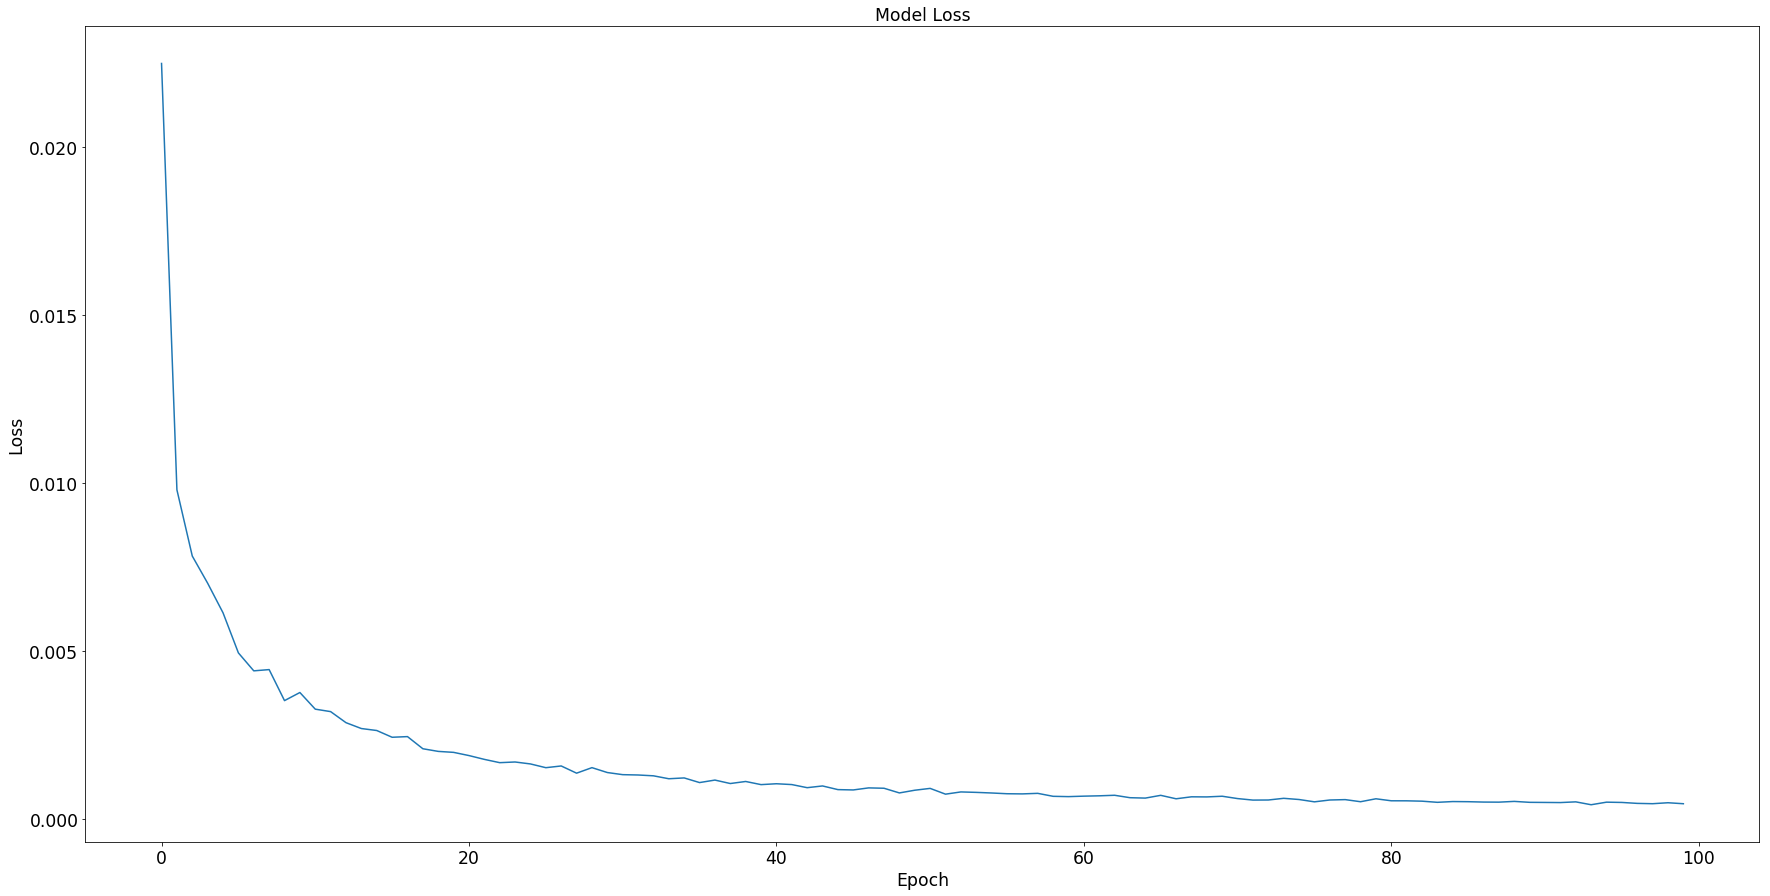

In [16]:
plot_loss(lstm_history)

In [17]:
lstm_mse = calculate_mse(x_test, y_test, lstm_model)
'Mean Square Error for LSTM is {}.'.format(lstm_mse)

'Mean Square Error for LSTM is [0.05802761].'

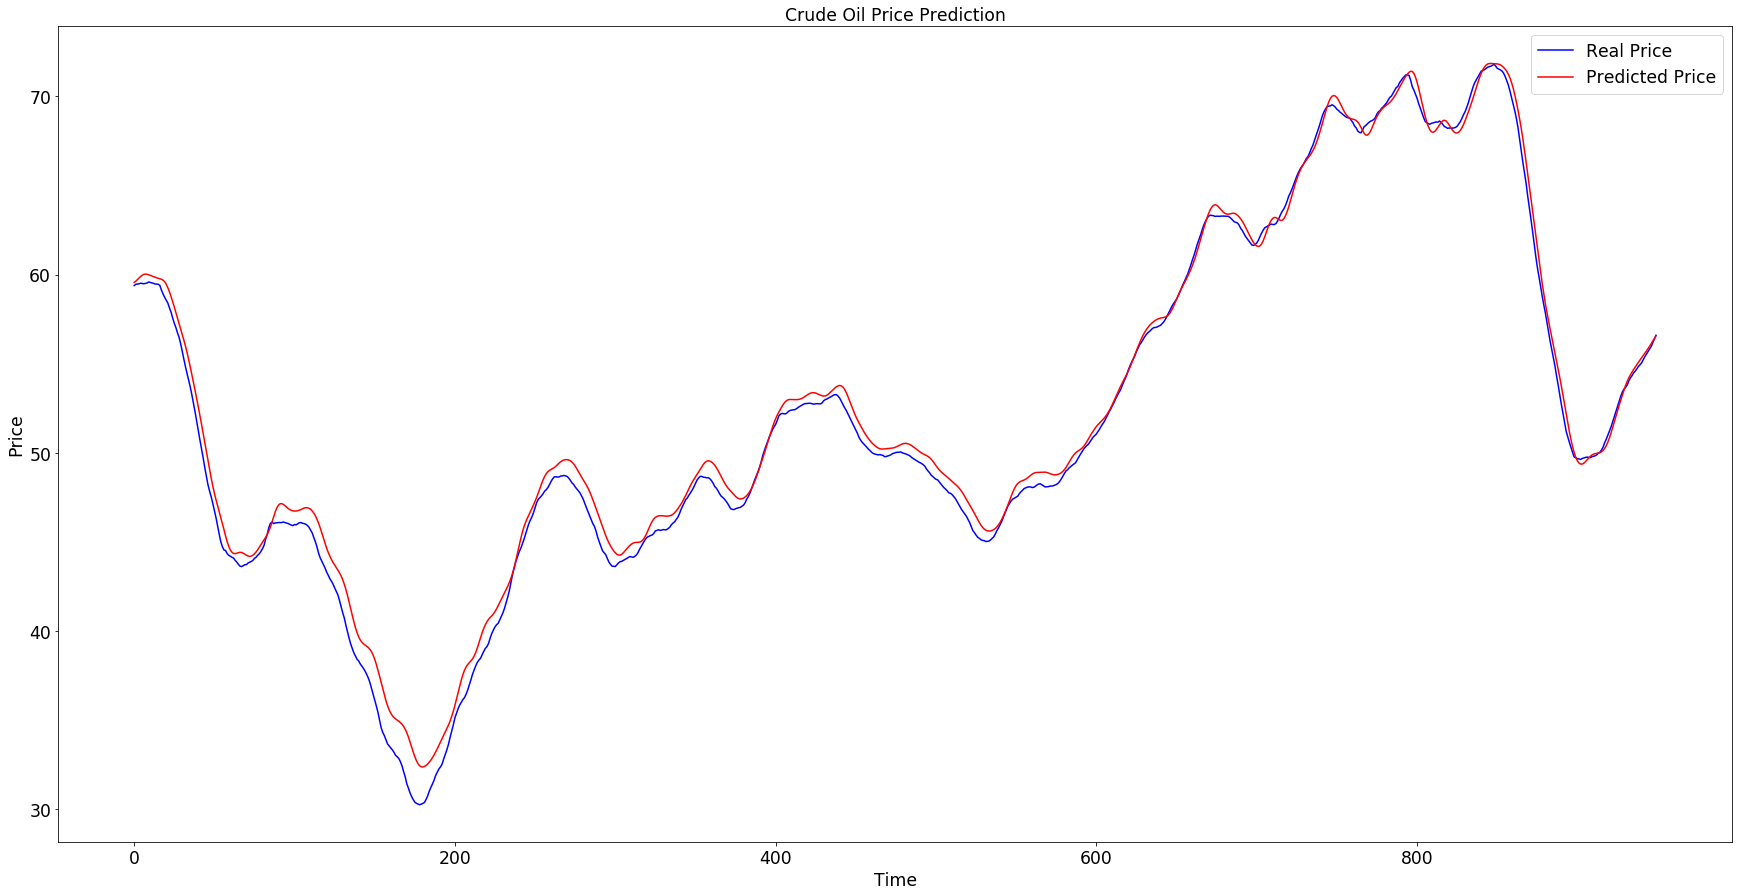

In [18]:
plot_prediction(scaler, x_test, y_test, lstm_model)

# GRU Model

In [19]:
gru_model, gru_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'gru')

Epoch 1/100
1950/1950 [==============================] - 7s 4ms/step - loss: 0.0190
Epoch 2/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0077
Epoch 3/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0061
Epoch 4/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0056
Epoch 5/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0049
Epoch 6/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0041
Epoch 7/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0036
Epoch 8/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0038
Epoch 9/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0035
Epoch 10/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0031
Epoch 11/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0028
Epoch 12/100
1950/1950 [==============================] - 5s 3ms/step - lo

1950/1950 [==============================] - 5s 3ms/step - loss: 4.1939e-04
Epoch 96/100
1950/1950 [==============================] - 5s 3ms/step - loss: 4.3962e-04
Epoch 97/100
1950/1950 [==============================] - 5s 3ms/step - loss: 3.9124e-04
Epoch 98/100
1950/1950 [==============================] - 5s 3ms/step - loss: 4.2850e-04
Epoch 99/100
1950/1950 [==============================] - 5s 3ms/step - loss: 3.7436e-04
Epoch 100/100
1950/1950 [==============================] - 5s 3ms/step - loss: 4.1028e-04


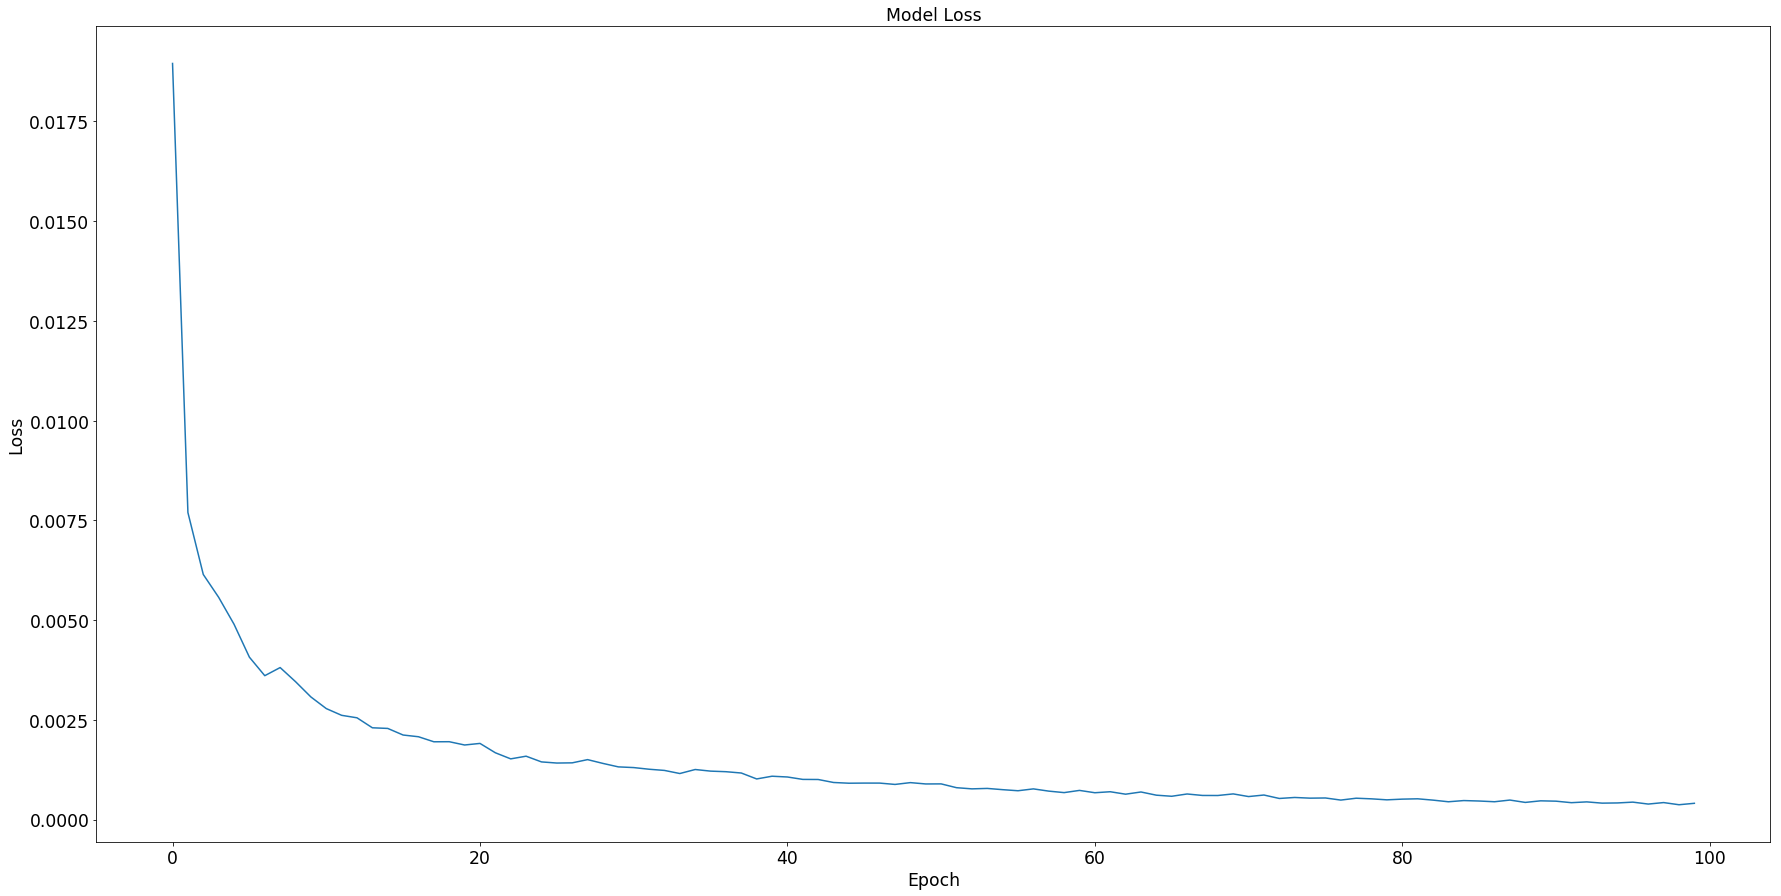

In [20]:
plot_loss(gru_history)

In [21]:
gru_mse = calculate_mse(x_test, y_test, gru_model)
'Mean Square Error for GRU is {}.'.format(gru_mse)

'Mean Square Error for GRU is [0.08678879].'

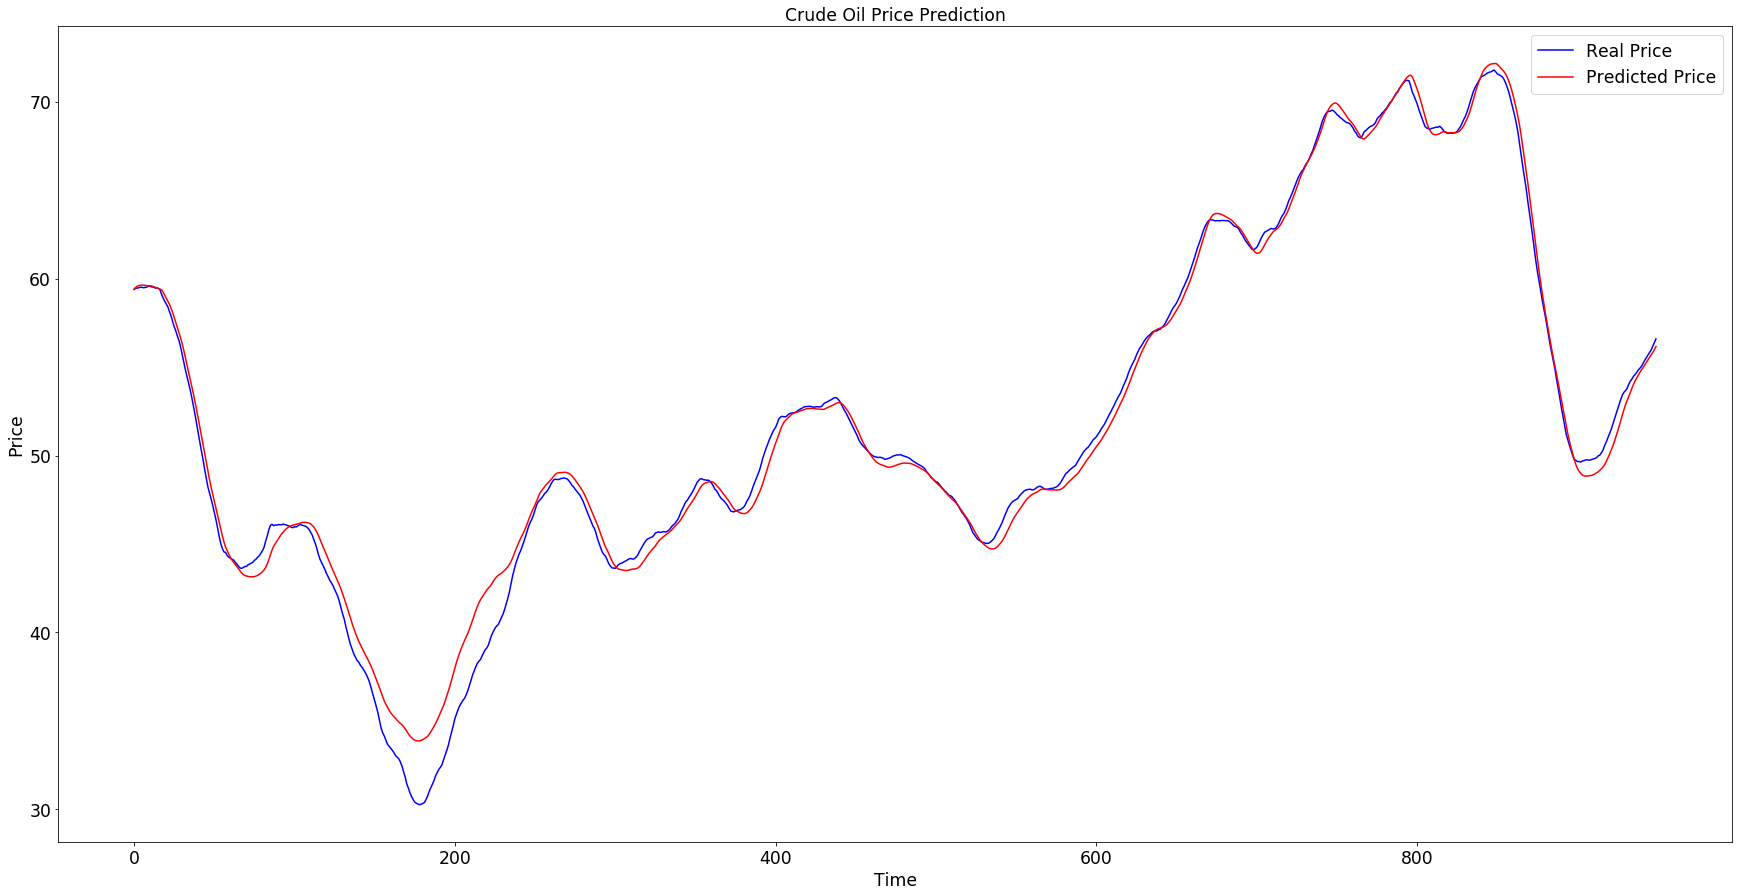

In [22]:
plot_prediction(scaler, x_test, y_test, gru_model)